# Binary Classification on the MIT-BIH Arrhythmia Dataset 
*Float Data and Float Neural Net*

In [1]:
import h5py
from pathlib import Path
from copy import deepcopy

import torch
from torch.utils.data import DataLoader, Dataset

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [2]:
print(f'torch version: {torch.__version__}')

torch version: 1.8.1+cu102


Needed paths

In [5]:
project_path = Path.cwd().parent
project_path
train_path = project_path / 'data' / 'mit-bih' / 'mitbih_train.hdf5'
test_path = project_path / 'data' / 'mit-bih' / 'mitbih_test.hdf5'

## Dataset

In [6]:
class BinaryECG(Dataset):
    """The class used by the client to load the dataset

    Args:
        Dataset ([type]): [description]
    """
    def __init__(self, train_path: Path, test_path: Path, train=True):
        if train:
            with h5py.File(train_path, 'r') as hdf:
                self.x = hdf['x_train'][:]
                self.y = hdf['y_train'][:]
                self.binary_y = deepcopy(self.y)  # for binary classification
                self.binary_y[self.binary_y > 0] = 1
        else:
            with h5py.File(test_path, 'r') as hdf:
                self.x = hdf['x_test'][:]
                self.y = hdf['y_test'][:]
                self.binary_y = deepcopy(self.y)
                self.binary_y[self.binary_y > 0] = 1
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return torch.tensor(self.x[idx], dtype=torch.float), torch.tensor(self.binary_y[idx])

In [7]:
batch_size = 4
train_dataset = BinaryECG(train=True, train_path=train_path, test_path=test_path)
test_dataset = BinaryECG(train=False, train_path=train_path, test_path=test_path)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [8]:
print(train_dataset.x.shape)
print(train_dataset.y.shape)
print(test_dataset.x.shape)
print(test_dataset.y.shape)

(13245, 1, 128)
(13245,)
(13245, 1, 128)
(13245,)


(1, 128)


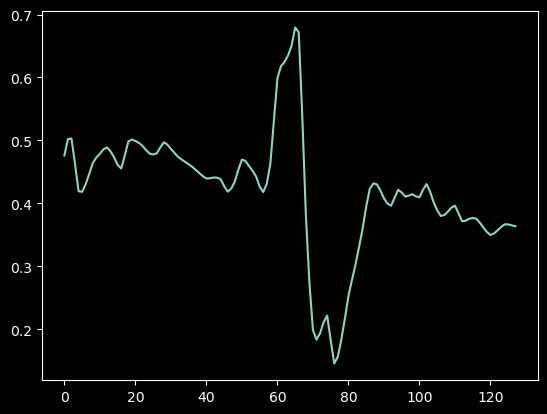

In [9]:
x0 = train_dataset.x[0]
print(x0.shape)
plt.plot(x0[0])

In [10]:
x0

array([[0.47613414, 0.5020567 , 0.50298215, 0.46231327, 0.41928844,
        0.41842108, 0.43061455, 0.44688531, 0.46408802, 0.47293354,
        0.47899632, 0.48582534, 0.48893095, 0.48258178, 0.47326914,
        0.46113493, 0.455493  , 0.47573456, 0.49812282, 0.50142268,
        0.49909754, 0.4960816 , 0.49134992, 0.4847633 , 0.47915717,
        0.47762139, 0.47941395, 0.48882176, 0.49701847, 0.49347912,
        0.48651553, 0.48023663, 0.47407637, 0.46977147, 0.46597436,
        0.46211728, 0.45808918, 0.45318487, 0.44824447, 0.44322334,
        0.43951277, 0.43997245, 0.4410783 , 0.44093789, 0.43854472,
        0.42746798, 0.41866831, 0.42362392, 0.43467756, 0.45355196,
        0.46949916, 0.46741965, 0.45934733, 0.45182872, 0.44276687,
        0.42654805, 0.41805189, 0.43117256, 0.46263137, 0.53157473,
        0.59875968, 0.61784347, 0.62479582, 0.63498664, 0.65088522,
        0.67939663, 0.6717122 , 0.53892088, 0.38295176, 0.27504905,
        0.19901058, 0.18376322, 0.19361621, 0.21

In [8]:
print(f"{train_dataset.binary_y = }")
print(f"{train_dataset.y = }")

unique, train_counts = np.unique(train_dataset.binary_y, return_counts=True)
print(f"there are {train_counts[0]} normal beats and {train_counts[1]} abnormal beats in the train dataset")
unique, test_counts = np.unique(test_dataset.binary_y, return_counts=True)
print(f"there are {test_counts[0]} normal beats and {test_counts[1]} abnormal beats in the train dataset")

train_dataset.binary_y = array([1, 1, 1, ..., 1, 1, 0])
train_dataset.y = array([2, 4, 2, ..., 1, 4, 0])
there are 3000 normal beats and 10245 abnormal beats in the train dataset
there are 3000 normal beats and 10245 abnormal beats in the train dataset


## Model

A simple linear regression model

In [9]:
class LinearModel(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = torch.nn.Linear(input_size, output_size)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, x):
        y_pred = self.linear(x)
        y_pred = self.sigmoid(y_pred)
        return y_pred

## Training

Set the parameters, random seed and the device.

In [10]:
epoch = 500 
lr = 0.001

In [11]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f'device: {torch.cuda.get_device_name(0)}')

lr_model = LinearModel(128, 1)
lr_model.to(device)
lr_model

device: NVIDIA GeForce RTX 2060


LinearModel(
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [13]:
for param in lr_model.parameters():
    print(param)

Parameter containing:
tensor([[-0.0007,  0.0474, -0.0727, -0.0650, -0.0340,  0.0237, -0.0018,  0.0701,
         -0.0078,  0.0234, -0.0267, -0.0174, -0.0844, -0.0585, -0.0364,  0.0033,
          0.0349,  0.0530, -0.0599, -0.0385,  0.0321,  0.0734, -0.0182,  0.0661,
         -0.0142,  0.0094,  0.0800, -0.0820, -0.0556, -0.0224, -0.0345,  0.0764,
         -0.0573, -0.0407, -0.0618, -0.0828, -0.0516,  0.0760,  0.0394,  0.0428,
          0.0046, -0.0453,  0.0150, -0.0825, -0.0639, -0.0456,  0.0558,  0.0518,
         -0.0392, -0.0032,  0.0565,  0.0879,  0.0351,  0.0119,  0.0593, -0.0520,
          0.0165, -0.0685, -0.0613, -0.0457,  0.0400,  0.0355, -0.0524,  0.0267,
          0.0485, -0.0112,  0.0034,  0.0205,  0.0548,  0.0849, -0.0681, -0.0324,
          0.0347,  0.0732,  0.0769,  0.0780,  0.0176, -0.0769,  0.0081, -0.0553,
         -0.0824,  0.0785,  0.0672, -0.0882,  0.0165, -0.0149, -0.0145, -0.0405,
          0.0340, -0.0524,  0.0324,  0.0447,  0.0633,  0.0330, -0.0875, -0.0573,
      

Training and testing process

In [14]:
def train(model):
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for e in range(epoch):
        print(f"--------- epoch: {e+1} ---------")
        # training
        train_loss = 0.0
        corrects = 0
        total_examples = 0
        for i, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()  # zero the gradients
            # prepare data
            x = x.to(device)
            y = y.to(device).to(torch.float32)
            # the forward pass
            y_pred = model(x)
            y_pred = y_pred.reshape(y.shape)
            # the backward pass
            loss = criterion(y_pred, y)  # calculate the loss
            loss.backward()  # get the gradients
            optimizer.step()  # update the params based on the gradients
            # collect training results
            train_loss += loss.item()
            corrects += torch.sum((y_pred.round() == y))
            total_examples += len(y)

        train_losses.append(train_loss.item() / len(train_loader))
        train_accuracies.append(corrects / total_examples)
        print(f"num_corrects / total_examples = {corrects.item()} / {total_examples}")
        print(f"training loss = {train_losses[-1]:.4f}")
        print(f"training accuracy = {train_accuracies[-1]:.4f}")
        # print(total_examples)

        # testing
        test_corrects = 0
        test_total_examples = 0
        with torch.no_grad():
            for i, (x, y) in enumerate(test_loader):
                # prepare data
                x = x.to(device)
                y = y.to(device).to(torch.float32)
                # the forward pass
                y_pred = model(x)
                y_pred = y_pred.reshape(y.shape)
                # collect testing results
                test_corrects += torch.sum((y_pred.round() == y))
                test_total_examples += len(y)

        test_accuracies.append(test_corrects.item() / test_total_examples)
        print(f"num_test_corrects / test_total_examples = {test_corrects.item()} / {test_total_examples}")
        print(f"testing accuracy = {test_accuracies[-1]:.4f}")

    return train_losses, train_accuracies, test_accuracies

train_losses, train_accuracies, test_accuracies = train(lr_model)

--------- epoch: 1 ---------
num_corrects / total_examples = 10232 / 13245
training loss = 0.5232
training accuracy = 0.7725
num_test_corrects / test_total_examples = 10245 / 13245
testing accuracy = 0.7735
--------- epoch: 2 ---------
num_corrects / total_examples = 10253 / 13245
training loss = 0.4939
training accuracy = 0.7741
num_test_corrects / test_total_examples = 10251 / 13245
testing accuracy = 0.7740
--------- epoch: 3 ---------
num_corrects / total_examples = 10283 / 13245
training loss = 0.4756
training accuracy = 0.7764
num_test_corrects / test_total_examples = 10275 / 13245
testing accuracy = 0.7758
--------- epoch: 4 ---------
num_corrects / total_examples = 10311 / 13245
training loss = 0.4627
training accuracy = 0.7785
num_test_corrects / test_total_examples = 10274 / 13245
testing accuracy = 0.7757
--------- epoch: 5 ---------
num_corrects / total_examples = 10325 / 13245
training loss = 0.4530
training accuracy = 0.7795
num_test_corrects / test_total_examples = 10307

Visualizing the results

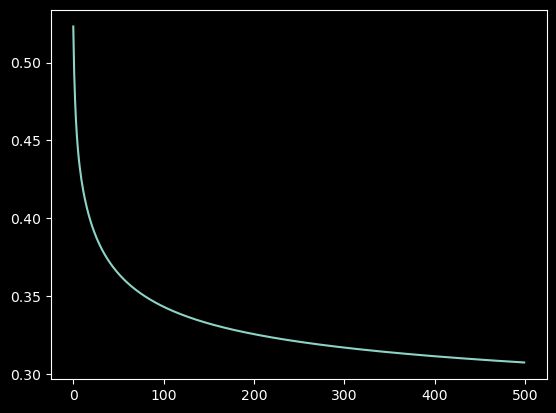

In [16]:
plt.plot(train_losses)

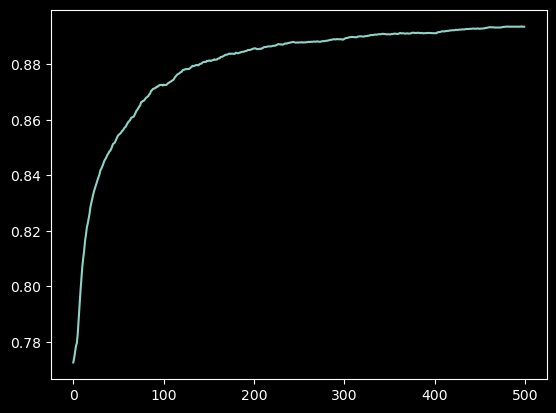

In [19]:
plt.plot(train_accuracies)

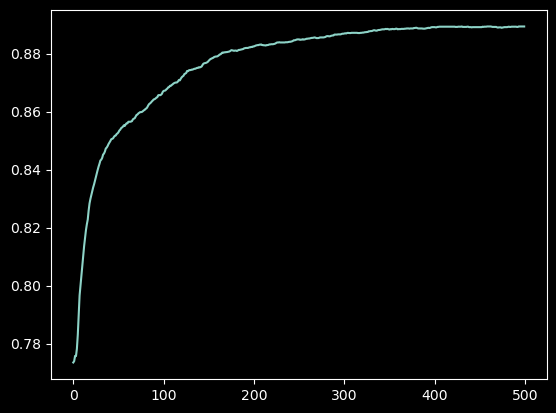

In [22]:
plt.plot(test_accuracies)

In [28]:
print(f"max train accuracy = {max(train_accuracies)}")
print(f"max test accuracy = {max(test_accuracies)}")

max train accuracy = 0.8936202526092529
max test accuracy = 0.889316737651825


In [30]:
for param in lr_model.parameters():
    print(param)

Parameter containing:
tensor([[-7.0805e-01,  2.2928e-01, -1.0808e+00, -1.1814e+00, -1.2394e+00,
         -1.0086e+00, -8.0494e-01, -4.2681e-01, -1.4453e-01,  2.6786e-01,
          6.0523e-01,  1.0209e+00,  1.2789e+00,  1.3858e+00,  1.3914e+00,
          1.4229e+00,  1.3957e+00,  1.2809e+00,  1.0406e+00,  9.8646e-01,
          1.0232e+00,  1.0591e+00,  1.0071e+00,  1.2150e+00,  1.2869e+00,
          1.4050e+00,  1.5281e+00,  1.4550e+00,  1.4493e+00,  1.1187e+00,
          6.0982e-01,  2.4857e-01, -4.4515e-01, -1.1483e+00, -1.9852e+00,
         -2.9140e+00, -3.7426e+00, -4.2107e+00, -4.6396e+00, -4.8207e+00,
         -4.9198e+00, -5.0579e+00, -4.9247e+00, -4.7342e+00, -4.0362e+00,
         -2.5876e+00, -7.4479e-01,  1.1280e+00,  2.7342e+00,  3.7398e+00,
          4.4966e+00,  4.8508e+00,  5.3535e+00,  7.6177e+00,  9.5119e+00,
          9.2978e+00,  7.7093e+00,  2.8428e+00, -1.6147e+00, -1.7053e+00,
         -1.4594e+00, -4.9289e+00, -7.1145e+00, -2.5885e+00,  1.4174e+00,
          4.9473